In [1]:
import pickle
import random
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

Data Preparation

In [2]:
def load_images(benign_path, malicious_path, size=(256, 256)):
    benign_files, malicious_files = list(), list()
    for file in tqdm(os.listdir(benign_path)):
        benign_files.append(os.path.join(benign_path, file))
    for file in tqdm(os.listdir(malicious_path)):
        malicious_files.append(os.path.join(malicious_path, file))

    benign_images, malicious_images = list(), list()
    for file in tqdm(benign_files):
        image = cv2.imread(file)
        resized_image = cv2.resize(image, size)
        benign_images.append(resized_image)
    for file in tqdm(malicious_files):
        image = cv2.imread(file)
        resized_image = cv2.resize(image, size)
        malicious_images.append(resized_image)

    return np.array(benign_images), np.array(malicious_images)

In [51]:
benign_path = '/Applications/ML projects/Success/Mal-cGAN/Dataset/preprocessed-data-revised/benign'
malicious_path = '/Applications/ML projects/Success/Mal-cGAN/Dataset/preprocessed-data-revised/malicious'
npz_file_name = '/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/img_256.npz'
benign_images, malicious_images = load_images(benign_path, malicious_path)
np.savez_compressed(npz_file_name, benign_images, malicious_images)
print('Saved Dataset: ', npz_file_name)

100%|██████████| 85/85 [00:00<00:00, 390.37it/s]


Saved Dataset:  /Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/img_256.npz


In [4]:
npz_file_name = '/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/IMGS_256.npz'
data = np.load(npz_file_name)
benign, malicious = data['arr_0'], data['arr_1']
print('Loaded: ', benign.shape, malicious.shape)

Loaded:  (61, 256, 256, 3) (85, 256, 256, 3)


In [5]:
n_samples = 3

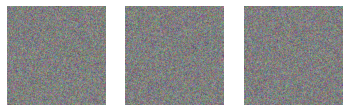

In [6]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(benign[i].astype('uint8'))

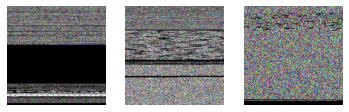

In [7]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(malicious[i].astype('uint8'))

In [8]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Flatten, Dropout, BatchNormalization, LeakyReLU, Dense, Concatenate, Lambda
from keras import backend as K

Substitute Detector

In [9]:
def SubstituteDetector(input_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.2)
    input = Input(input_shape)

    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(input)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)   

    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)   

    d = Flatten()(d)
    d = Dense(units=8192, activation='relu')(d)
    d = Dense(units=2048, activation='relu')(d)
    output = Dense(units=2, activation='softmax')(d)

    model = Model(input, output)
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

In [10]:
substituteDetector = SubstituteDetector()
substituteDetector.summary()

2023-10-05 15:17:01.372595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

Generator

In [11]:
def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.2)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [12]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.2)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

In [13]:
def Generator(input_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.2)
    input = Input(input_shape)

    e0 = encoder_block(input, 64, batchnorm=False)
    e1 = encoder_block(e0, 128)
    e2 = encoder_block(e1, 256)
    e3 = encoder_block(e2, 512)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)

    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e5)
    b = Activation('relu')(b)

    d5 = decoder_block(b, e5, 512)
    d4 = decoder_block(d5, e4, 512)
    d3 = decoder_block(d4, e3, 512)
    d2 = decoder_block(d3, e2, 256)
    d1 = decoder_block(d2, e1, 128)
    d0 = decoder_block(d1, e0, 64)

    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d0)
    output = Activation('sigmoid')(g)

    model = Model(input, output)
    return model

In [14]:
generator = Generator()

In [15]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  3136        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_5[0][0]']               
                                )                                                           

Black Box 

In [17]:
black_box_model_path = '/Applications/ML projects/Success/Mal-cGAN/Models/BlackBox.pkl'
with open(black_box_model_path, 'rb') as file:
    blackBox = pickle.load(file)

MalGAN

In [18]:
def MalGAN(generator, substituteDetector, input_shape=(256, 256, 3)):
    for layer in substituteDetector.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    source = Input(input_shape)
    gen_out = generator(source)
    sd_probabilities = substituteDetector(gen_out)
    sd_out = sd_probabilities[:,1]

    model = Model(source, [sd_out, gen_out])
    optimizer = Adam(learning_rate=0.0002)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimizer, loss_weights=[1, 100])
    return model

In [19]:
malGAN = MalGAN(generator, substituteDetector)

In [20]:
malGAN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model_1 (Functional)        (None, 256, 256, 3)       41841283  
                                                                 
 model (Functional)          (None, 2)                 292184002 
                                                                 
 tf.__operators__.getitem (S  (None,)                  0         
 licingOpLambda)                                                 
                                                                 
Total params: 334,025,285
Trainable params: 41,836,291
Non-trainable params: 292,188,994
_________________________________________________________________


Data

In [21]:
def load_samples(filename):
    data = np.load(filename)
    benign, malicious = data['arr_0'], data['arr_1']
    benign = benign / 255.0
    malicious = malicious / 255.0
    return benign, malicious

In [22]:
def get_batches(benign, malicious, batch_size):
    benign_size = benign.shape[0]
    malicious_size = malicious.shape[0]

    max_size = max(benign_size, malicious_size)
    benign_batches, malicious_batches = list(), list()
    b_idx, m_idx = -1, -1
    for _ in range(max_size // batch_size):
        benign_batch = list()
        malicious_batch = list()
        for _ in range(batch_size):
            b_idx = (b_idx + 1) % benign_size
            m_idx = (m_idx + 1) % malicious_size
            benign_batch.append(benign[b_idx])
            malicious_batch.append(malicious[m_idx])
        benign_batch = np.array(benign_batch)
        malicious_batch = np.array(malicious_batch)
        benign_batches.append(benign_batch)
        malicious_batches.append(malicious_batch)
    return np.array(benign_batches), np.array(malicious_batches)

In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
label_encoder = LabelEncoder()


In [24]:
def get_labels(generator, blackBox, benign_batch, malicious_batch, label_encoder=label_encoder):
    X = generator.predict(malicious_batch)
    bb_samples = np.concatenate((benign_batch, X), axis=0)
    reshaped_bb_samples = bb_samples.reshape(bb_samples.shape[0], -1)
    bb_predictions = blackBox.predict(reshaped_bb_samples)
    numerical_labels = label_encoder.fit_transform(bb_predictions)
    onehot_labels = to_categorical(numerical_labels, num_classes=2)
    return bb_samples, onehot_labels

In [25]:
def train_step(substituteDetector, malGAN, malicious_batch, bb_batch, bb_labels):
    substituteDetector_loss = substituteDetector.train_on_batch(bb_batch, bb_labels)
    sd_out_mal = substituteDetector.predict(malicious_batch)[:,1]
    malicious_batch_labels = [sd_out_mal, malicious_batch]
    generator_loss = malGAN.train_on_batch(malicious_batch, malicious_batch_labels)
    return substituteDetector_loss, generator_loss

In [27]:
def train(generator, blackBox, substituteDetector, malGAN, dataset, epochs=50, batch_size=8):
    benign, malicious = dataset
    batches = get_batches(benign, malicious, batch_size)
    benign_batches, malicious_batches = batches[0], batches[1]
    batches_count = benign_batches.shape[0]

    for epoch in range(epochs):
        for idx in range(batches_count):
            benign_batch, malicious_batch = benign_batches[idx], malicious_batches[idx]
            bb_batch, bb_labels = get_labels(generator, blackBox, benign_batch, malicious_batch)
            substituteDetector_loss, generator_loss = train_step(substituteDetector, malGAN, malicious_batch, bb_batch, bb_labels)
        print((epoch, substituteDetector_loss, generator_loss))

In [28]:
data_file = '/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/IMGS_256.npz'
dataset = load_samples(data_file)
print('Loaded: ', dataset[0].shape, dataset[1].shape)

Loaded:  (61, 256, 256, 3) (85, 256, 256, 3)


In [29]:
benign, malicious = dataset

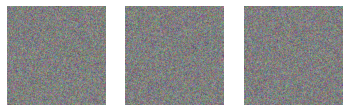

In [30]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(benign[i])

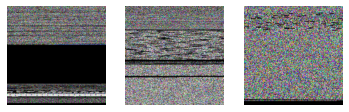

In [31]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(malicious[i])

In [32]:
train(generator, blackBox, substituteDetector, malGAN, dataset)

1/1 [==============================] - 0s 207ms/step
(0, 0.008074093610048294, [40.04544448852539, 3.7252959828038e-07, 0.40045443177223206])
1/1 [==============================] - 0s 172ms/step
(1, 7.425403070193681e-10, [38.73337173461914, 7.226171874208376e-05, 0.3873329758644104])
1/1 [==============================] - 0s 172ms/step
(2, 2.5289341731848936e-09, [37.541595458984375, 6.795107765356079e-06, 0.3754158914089203])
1/1 [==============================] - 0s 181ms/step
(3, 7.720325712057274e-09, [36.465972900390625, 3.5104363632854074e-05, 0.3646593689918518])
1/1 [==============================] - 0s 223ms/step
(4, 1.690310824642438e-08, [35.48774719238281, 0.0015886841574683785, 0.35486161708831787])
1/1 [==============================] - 0s 221ms/step
(5, 4.9688580361362256e-08, [34.59446334838867, 0.013976006768643856, 0.3458048701286316])
1/1 [==============================] - 0s 195ms/step
(6, 6.316344070000923e-08, [34.22141647338867, 0.4131096303462982, 0.33808308839

In [33]:
generator.save('/Applications/ML projects/Success/Mal-cGAN/Models/generator.h5')
substituteDetector.save('/Applications/ML projects/Success/Mal-cGAN/Models/substituteDetector.h5')
malGAN.save('/Applications/ML projects/Success/Mal-cGAN/Models/mal-cGAN.h5')

In [36]:
from keras.models import load_model

In [37]:
def adversarial_dataset(dataset_file='/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/imgs_256.npz', generator_file='/Applications/ML projects/Success/Mal-cGAN/Models/generator.h5'):
    dataset = np.load(dataset_file)
    benign, malicious = dataset['arr_0'], dataset['arr_1']
    benign = benign / 255.0
    malicious = malicious / 255.0
    generator = load_model(generator_file)
    adversarial = generator.predict(malicious)
    benign, malicious, adversarial = benign * 255.0, malicious * 255.0, adversarial * 255.0
    mal_adv = np.concatenate((malicious, adversarial), axis=0)
    npz_file = '/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/adv_imgs_256.npz'
    np.savez_compressed(npz_file, benign, mal_adv)
    print('Saved Dataset: ', npz_file.split('/')[-1])
    return

In [38]:
adversarial_dataset()

3/3 [==============================] - 7s 2s/step
Saved Dataset:  adv_imgs_256-git.npz


In [39]:
data_file = '/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/adv_imgs_256.npz'
adv_dataset = load_samples(data_file)
print('Loaded: ', adv_dataset[0].shape, adv_dataset[1].shape)

Loaded:  (61, 256, 256, 3) (170, 256, 256, 3)


In [40]:
adv_benign, adv_malicious = adv_dataset

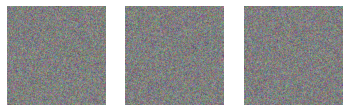

In [41]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(adv_benign[i])

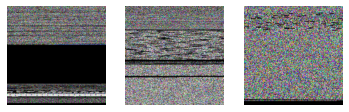

In [42]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(adv_malicious[i])

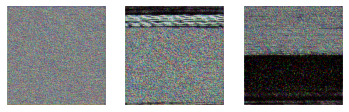

In [43]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(adv_malicious[-i-1])

In [44]:
def generate_samples(dataset_file='/Applications/ML projects/Success/Mal-cGAN/Numpy Dataset/imgs_256.npz', generator_file='/Applications/ML projects/Success/Mal-cGAN/Models/generator.h5'):
    dataset = np.load(dataset_file)
    _, malicious = dataset['arr_0'], dataset['arr_1']
    malicious = malicious / 255.0
    generator = load_model(generator_file)
    adversarial = generator.predict(malicious)
    return adversarial

In [45]:
adversarial_samples = generate_samples()

3/3 [==============================] - 9s 2s/step


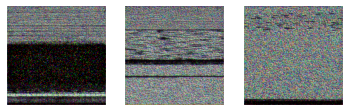

In [46]:
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(adversarial_samples[i])

In [47]:
def save_samples(samples, path):
    if not os.path.exists(path):
        os.makedirs(path)
    count = 0
    for sample in tqdm(samples):
        sample_name = 'sample - ' + str(count) + '.png'
        sample_path = os.path.join(path, sample_name)
        plt.imsave(sample_path, sample)
        count += 1
    print('Saved Samples to ' + path)
    return

In [49]:
save_samples(adversarial_samples, '/Applications/ML projects/Success/Mal-cGAN/Samples')

100%|██████████| 85/85 [00:02<00:00, 29.94it/s]

Saved Samples to /Applications/ML projects/Success/Mal-cGAN/Samples
